# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

# Configuration

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
seq_len = 25
batch_size = 15
min_freq = 0

num_epochs = 100

max_lr_dec = 3
lr_dec = 0


# Utils

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [4]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [14]:
char2ind = {}
def data_init():
    global char2ind
    with open("./wikitext-2/train.txt", encoding="utf8") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("./wikitext-2/valid.txt", encoding="utf8") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("./wikitext-2/test.txt", encoding="utf8") as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return torch.tensor(trn,dtype=torch.int64), torch.tensor(vld,dtype=torch.int64), torch.tensor(tst,dtype=torch.int64), len(words)

def findWordByToken(iToken):
    for word, toekn in char2ind.items():  
        if toekn == iToken:
            return word
    return ''

In [15]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

In [16]:
train_tokens_voc , valid_tokens_voc , test_tokens_voc , vocab_size= data_init()

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [6]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, hidden = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, hidden = self.rnn2(output,hidden)
    output = self.dropout2(output)
    
    output, hidden = self.rnn3(output,hidden)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output

# Train

## Learning Functions

In [7]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [8]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [17]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25


model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
model = model.to(device)

loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0

model

H_LSTM(
  (embedding): Embedding(33278, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33278, bias=True)
)

In [18]:
num_trainable_params(model)

39.323278

## Learning Loop

In [19]:

lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [20]:
num_epochs = 300
max_lr_dec = 5
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

  0%|          | 0/5570 [00:00<?, ?batch/s]/tmp/ipykernel_16042/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)
Epoch 0: 100%|██████████| 5570/5570 [01:51<00:00, 49.84batch/s, loss=6.19, perplexity=631]    


Valid: Loss = 5.546 Perplexity= 268.3, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 5570/5570 [01:38<00:00, 56.62batch/s, loss=5.3, perplexity=216] 


Valid: Loss = 4.765 Perplexity= 122.7, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 5570/5570 [01:31<00:00, 61.20batch/s, loss=4.67, perplexity=114]


Valid: Loss = 4.335 Perplexity= 79.76, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 5570/5570 [01:30<00:00, 61.57batch/s, loss=4.34, perplexity=81.6]


Valid: Loss = 4.13 Perplexity= 65.08, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 5570/5570 [01:31<00:00, 60.87batch/s, loss=4.08, perplexity=62.4]


Valid: Loss = 3.954 Perplexity= 54.59, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 5570/5570 [01:31<00:00, 60.63batch/s, loss=3.88, perplexity=51.2]


Valid: Loss = 3.796 Perplexity= 46.68, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 5570/5570 [01:31<00:00, 61.03batch/s, loss=3.77, perplexity=45.9]


Valid: Loss = 3.813 Perplexity= 47.4, LR = 0.5



Epoch 7: 100%|██████████| 5570/5570 [01:31<00:00, 60.88batch/s, loss=3.51, perplexity=35.5]


Valid: Loss = 3.504 Perplexity= 34.92, LR = 0.25
Model Saved!



Epoch 8: 100%|██████████| 5570/5570 [01:31<00:00, 60.89batch/s, loss=3.37, perplexity=30.7]


Valid: Loss = 3.448 Perplexity= 32.99, LR = 0.25
Model Saved!



Epoch 9: 100%|██████████| 5570/5570 [01:31<00:00, 61.15batch/s, loss=3.28, perplexity=28]  


Valid: Loss = 3.357 Perplexity= 30.12, LR = 0.25
Model Saved!



Epoch 10: 100%|██████████| 5570/5570 [01:31<00:00, 60.94batch/s, loss=3.18, perplexity=25.2]


Valid: Loss = 3.298 Perplexity= 28.39, LR = 0.25
Model Saved!



Epoch 11: 100%|██████████| 5570/5570 [01:31<00:00, 60.68batch/s, loss=3.06, perplexity=22.4]


Valid: Loss = 3.195 Perplexity= 25.58, LR = 0.25
Model Saved!



Epoch 12: 100%|██████████| 5570/5570 [01:32<00:00, 60.11batch/s, loss=3.04, perplexity=21.8]


Valid: Loss = 3.131 Perplexity= 24.0, LR = 0.25
Model Saved!



Epoch 13: 100%|██████████| 5570/5570 [01:31<00:00, 61.01batch/s, loss=2.88, perplexity=18.5]


Valid: Loss = 2.993 Perplexity= 20.9, LR = 0.25
Model Saved!



Epoch 14: 100%|██████████| 5570/5570 [01:31<00:00, 60.78batch/s, loss=2.76, perplexity=16.5]


Valid: Loss = 2.927 Perplexity= 19.52, LR = 0.25
Model Saved!



Epoch 15: 100%|██████████| 5570/5570 [01:31<00:00, 60.68batch/s, loss=2.68, perplexity=15.2]


Valid: Loss = 2.864 Perplexity= 18.34, LR = 0.25
Model Saved!



Epoch 16: 100%|██████████| 5570/5570 [01:31<00:00, 60.99batch/s, loss=2.67, perplexity=15.1]


Valid: Loss = 2.933 Perplexity= 19.69, LR = 0.25



Epoch 17: 100%|██████████| 5570/5570 [01:32<00:00, 60.33batch/s, loss=2.32, perplexity=10.6]


Valid: Loss = 2.521 Perplexity= 13.01, LR = 0.125
Model Saved!



Epoch 18: 100%|██████████| 5570/5570 [01:32<00:00, 60.26batch/s, loss=2.19, perplexity=9.23]


Valid: Loss = 2.444 Perplexity= 12.04, LR = 0.125
Model Saved!



Epoch 19: 100%|██████████| 5570/5570 [01:32<00:00, 60.37batch/s, loss=2.12, perplexity=8.66]


Valid: Loss = 2.391 Perplexity= 11.42, LR = 0.125
Model Saved!



Epoch 20: 100%|██████████| 5570/5570 [01:31<00:00, 60.75batch/s, loss=2.06, perplexity=8.15]


Valid: Loss = 2.358 Perplexity= 11.04, LR = 0.125
Model Saved!



Epoch 21: 100%|██████████| 5570/5570 [01:31<00:00, 60.59batch/s, loss=2.02, perplexity=7.82]


Valid: Loss = 2.291 Perplexity= 10.33, LR = 0.125
Model Saved!



Epoch 22: 100%|██████████| 5570/5570 [01:32<00:00, 60.18batch/s, loss=1.94, perplexity=7.15]


Valid: Loss = 2.276 Perplexity= 10.17, LR = 0.125
Model Saved!



Epoch 23: 100%|██████████| 5570/5570 [01:32<00:00, 60.26batch/s, loss=1.89, perplexity=6.81]


Valid: Loss = 2.178 Perplexity= 9.207, LR = 0.125
Model Saved!



Epoch 24: 100%|██████████| 5570/5570 [01:32<00:00, 60.24batch/s, loss=1.83, perplexity=6.39]


Valid: Loss = 2.162 Perplexity= 9.071, LR = 0.125
Model Saved!



Epoch 25: 100%|██████████| 5570/5570 [01:32<00:00, 60.20batch/s, loss=1.76, perplexity=5.96]


Valid: Loss = 2.073 Perplexity= 8.285, LR = 0.125
Model Saved!



Epoch 26: 100%|██████████| 5570/5570 [01:33<00:00, 59.86batch/s, loss=1.76, perplexity=5.97]


Valid: Loss = 2.105 Perplexity= 8.566, LR = 0.125



Epoch 27: 100%|██████████| 5570/5570 [01:33<00:00, 59.88batch/s, loss=1.53, perplexity=4.72]


Valid: Loss = 1.887 Perplexity= 6.864, LR = 0.0625
Model Saved!



Epoch 28: 100%|██████████| 5570/5570 [01:33<00:00, 59.64batch/s, loss=1.45, perplexity=4.38]


Valid: Loss = 1.852 Perplexity= 6.624, LR = 0.0625
Model Saved!



Epoch 29: 100%|██████████| 5570/5570 [01:33<00:00, 59.50batch/s, loss=1.44, perplexity=4.31]


Valid: Loss = 1.827 Perplexity= 6.464, LR = 0.0625
Model Saved!



Epoch 30: 100%|██████████| 5570/5570 [01:33<00:00, 59.75batch/s, loss=1.41, perplexity=4.17]


Valid: Loss = 1.805 Perplexity= 6.322, LR = 0.0625
Model Saved!



Epoch 31: 100%|██████████| 5570/5570 [01:33<00:00, 59.46batch/s, loss=1.37, perplexity=4]   


Valid: Loss = 1.787 Perplexity= 6.204, LR = 0.0625
Model Saved!



Epoch 32: 100%|██████████| 5570/5570 [01:32<00:00, 60.14batch/s, loss=1.34, perplexity=3.9] 


Valid: Loss = 1.752 Perplexity= 5.986, LR = 0.0625
Model Saved!



Epoch 33: 100%|██████████| 5570/5570 [01:32<00:00, 59.97batch/s, loss=1.31, perplexity=3.79]


Valid: Loss = 1.711 Perplexity= 5.744, LR = 0.0625
Model Saved!



Epoch 34: 100%|██████████| 5570/5570 [01:39<00:00, 55.73batch/s, loss=1.27, perplexity=3.63]


Valid: Loss = 1.681 Perplexity= 5.568, LR = 0.0625
Model Saved!



Epoch 35: 100%|██████████| 5570/5570 [01:54<00:00, 48.44batch/s, loss=1.26, perplexity=3.58]


Valid: Loss = 1.659 Perplexity= 5.45, LR = 0.0625
Model Saved!



Epoch 36: 100%|██████████| 5570/5570 [01:53<00:00, 49.01batch/s, loss=1.22, perplexity=3.45]


Valid: Loss = 1.626 Perplexity= 5.27, LR = 0.0625
Model Saved!



Epoch 37: 100%|██████████| 5570/5570 [01:34<00:00, 58.79batch/s, loss=1.2, perplexity=3.37] 


Valid: Loss = 1.603 Perplexity= 5.147, LR = 0.0625
Model Saved!



Epoch 38: 100%|██████████| 5570/5570 [01:34<00:00, 59.06batch/s, loss=1.19, perplexity=3.33]


Valid: Loss = 1.591 Perplexity= 5.08, LR = 0.0625
Model Saved!



Epoch 39: 100%|██████████| 5570/5570 [01:34<00:00, 58.70batch/s, loss=1.16, perplexity=3.22]


Valid: Loss = 1.571 Perplexity= 4.982, LR = 0.0625
Model Saved!



Epoch 40: 100%|██████████| 5570/5570 [01:34<00:00, 59.15batch/s, loss=1.14, perplexity=3.18]


Valid: Loss = 1.556 Perplexity= 4.904, LR = 0.0625
Model Saved!



Epoch 41: 100%|██████████| 5570/5570 [01:33<00:00, 59.48batch/s, loss=1.14, perplexity=3.16]


Valid: Loss = 1.537 Perplexity= 4.809, LR = 0.0625
Model Saved!



Epoch 42: 100%|██████████| 5570/5570 [01:34<00:00, 58.78batch/s, loss=1.1, perplexity=3.03] 


Valid: Loss = 1.538 Perplexity= 4.814, LR = 0.0625



Epoch 43: 100%|██████████| 5570/5570 [01:33<00:00, 59.27batch/s, loss=1, perplexity=2.76]   


Valid: Loss = 1.414 Perplexity= 4.244, LR = 0.03125
Model Saved!



Epoch 44: 100%|██████████| 5570/5570 [01:33<00:00, 59.64batch/s, loss=0.96, perplexity=2.64] 


Valid: Loss = 1.397 Perplexity= 4.171, LR = 0.03125
Model Saved!



Epoch 45: 100%|██████████| 5570/5570 [01:33<00:00, 59.85batch/s, loss=0.944, perplexity=2.6] 


Valid: Loss = 1.376 Perplexity= 4.085, LR = 0.03125
Model Saved!



Epoch 46: 100%|██████████| 5570/5570 [01:34<00:00, 58.72batch/s, loss=0.925, perplexity=2.55]


Valid: Loss = 1.375 Perplexity= 4.076, LR = 0.03125
Model Saved!



Epoch 47: 100%|██████████| 5570/5570 [01:34<00:00, 59.13batch/s, loss=0.913, perplexity=2.52]


Valid: Loss = 1.376 Perplexity= 4.083, LR = 0.03125



Epoch 48: 100%|██████████| 5570/5570 [01:33<00:00, 59.60batch/s, loss=0.88, perplexity=2.44] 


Valid: Loss = 1.314 Perplexity= 3.833, LR = 0.015625
Model Saved!



Epoch 49: 100%|██████████| 5570/5570 [01:34<00:00, 58.89batch/s, loss=0.862, perplexity=2.39]


Valid: Loss = 1.293 Perplexity= 3.754, LR = 0.015625
Model Saved!



Epoch 50: 100%|██████████| 5570/5570 [01:34<00:00, 58.86batch/s, loss=0.849, perplexity=2.36]


Valid: Loss = 1.283 Perplexity= 3.715, LR = 0.015625
Model Saved!



Epoch 51: 100%|██████████| 5570/5570 [01:33<00:00, 59.31batch/s, loss=0.841, perplexity=2.34]


Valid: Loss = 1.277 Perplexity= 3.691, LR = 0.015625
Model Saved!



Epoch 52: 100%|██████████| 5570/5570 [01:35<00:00, 58.53batch/s, loss=0.831, perplexity=2.32]


Valid: Loss = 1.272 Perplexity= 3.672, LR = 0.015625
Model Saved!



Epoch 53: 100%|██████████| 5570/5570 [01:33<00:00, 59.38batch/s, loss=0.826, perplexity=2.3] 


Valid: Loss = 1.264 Perplexity= 3.645, LR = 0.015625
Model Saved!



Epoch 54: 100%|██████████| 5570/5570 [01:34<00:00, 58.76batch/s, loss=0.816, perplexity=2.28]


Valid: Loss = 1.279 Perplexity= 3.699, LR = 0.015625



Epoch 55: 100%|██████████| 5570/5570 [01:33<00:00, 59.41batch/s, loss=0.804, perplexity=2.26]


Valid: Loss = 1.231 Perplexity= 3.521, LR = 0.0078125
Model Saved!



Epoch 56: 100%|██████████| 5570/5570 [01:33<00:00, 59.40batch/s, loss=0.796, perplexity=2.24]


Valid: Loss = 1.219 Perplexity= 3.48, LR = 0.0078125
Model Saved!



Epoch 57: 100%|██████████| 5570/5570 [01:34<00:00, 58.88batch/s, loss=0.79, perplexity=2.22] 


Valid: Loss = 1.217 Perplexity= 3.471, LR = 0.0078125
Model Saved!



Epoch 58: 100%|██████████| 5570/5570 [01:35<00:00, 58.53batch/s, loss=0.785, perplexity=2.21]


Valid: Loss = 1.216 Perplexity= 3.468, LR = 0.0078125
Model Saved!



Epoch 59: 100%|██████████| 5570/5570 [01:35<00:00, 58.29batch/s, loss=0.781, perplexity=2.2] 


Valid: Loss = 1.208 Perplexity= 3.441, LR = 0.0078125
Model Saved!



Epoch 60: 100%|██████████| 5570/5570 [01:35<00:00, 58.13batch/s, loss=0.776, perplexity=2.19]


Valid: Loss = 1.203 Perplexity= 3.424, LR = 0.0078125
Model Saved!



Epoch 61: 100%|██████████| 5570/5570 [01:34<00:00, 58.75batch/s, loss=0.772, perplexity=2.18]


Valid: Loss = 1.203 Perplexity= 3.421, LR = 0.0078125
Model Saved!



Epoch 62: 100%|██████████| 5570/5570 [01:35<00:00, 58.28batch/s, loss=0.768, perplexity=2.17]


Valid: Loss = 1.204 Perplexity= 3.426, LR = 0.0078125



Epoch 63: 100%|██████████| 5570/5570 [01:34<00:00, 58.75batch/s, loss=0.767, perplexity=2.17]


Valid: Loss = 1.182 Perplexity= 3.349, LR = 0.00390625
Model Saved!



Epoch 64: 100%|██████████| 5570/5570 [01:34<00:00, 59.19batch/s, loss=0.764, perplexity=2.16]


Valid: Loss = 1.177 Perplexity= 3.33, LR = 0.00390625
Model Saved!



Epoch 65: 100%|██████████| 5570/5570 [01:34<00:00, 58.84batch/s, loss=0.761, perplexity=2.16]


Valid: Loss = 1.176 Perplexity= 3.329, LR = 0.00390625
Model Saved!



Epoch 66: 100%|██████████| 5570/5570 [01:34<00:00, 58.96batch/s, loss=0.76, perplexity=2.16] 


Valid: Loss = 1.174 Perplexity= 3.322, LR = 0.00390625
Model Saved!



Epoch 67: 100%|██████████| 5570/5570 [01:35<00:00, 58.58batch/s, loss=0.758, perplexity=2.15]


Valid: Loss = 1.172 Perplexity= 3.316, LR = 0.00390625
Model Saved!



Epoch 68: 100%|██████████| 5570/5570 [01:35<00:00, 58.50batch/s, loss=0.755, perplexity=2.15]


Valid: Loss = 1.167 Perplexity= 3.297, LR = 0.00390625
Model Saved!



Epoch 69: 100%|██████████| 5570/5570 [01:36<00:00, 57.73batch/s, loss=0.753, perplexity=2.14]


Valid: Loss = 1.166 Perplexity= 3.295, LR = 0.00390625
Model Saved!



Epoch 70: 100%|██████████| 5570/5570 [01:34<00:00, 58.71batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.163 Perplexity= 3.283, LR = 0.00390625
Model Saved!



Epoch 71: 100%|██████████| 5570/5570 [01:36<00:00, 57.86batch/s, loss=0.749, perplexity=2.13]


Valid: Loss = 1.162 Perplexity= 3.282, LR = 0.00390625
Model Saved!



Epoch 72: 100%|██████████| 5570/5570 [01:35<00:00, 58.54batch/s, loss=0.746, perplexity=2.13]


Valid: Loss = 1.158 Perplexity= 3.268, LR = 0.00390625
Model Saved!



Epoch 73: 100%|██████████| 5570/5570 [01:34<00:00, 58.95batch/s, loss=0.745, perplexity=2.12]


Valid: Loss = 1.156 Perplexity= 3.26, LR = 0.00390625
Model Saved!



Epoch 74: 100%|██████████| 5570/5570 [01:35<00:00, 58.54batch/s, loss=0.743, perplexity=2.12]


Valid: Loss = 1.155 Perplexity= 3.258, LR = 0.00390625
Model Saved!



Epoch 75: 100%|██████████| 5570/5570 [01:36<00:00, 57.58batch/s, loss=0.74, perplexity=2.11] 


Valid: Loss = 1.151 Perplexity= 3.244, LR = 0.00390625
Model Saved!



Epoch 76: 100%|██████████| 5570/5570 [01:34<00:00, 58.89batch/s, loss=0.738, perplexity=2.11]


Valid: Loss = 1.151 Perplexity= 3.245, LR = 0.00390625



Epoch 77: 100%|██████████| 5570/5570 [01:35<00:00, 58.54batch/s, loss=0.743, perplexity=2.12]


Valid: Loss = 1.139 Perplexity= 3.206, LR = 0.001953125
Model Saved!



Epoch 78: 100%|██████████| 5570/5570 [01:35<00:00, 58.06batch/s, loss=0.744, perplexity=2.12]


Valid: Loss = 1.138 Perplexity= 3.203, LR = 0.001953125
Model Saved!



Epoch 79: 100%|██████████| 5570/5570 [01:35<00:00, 58.08batch/s, loss=0.745, perplexity=2.12]


Valid: Loss = 1.135 Perplexity= 3.191, LR = 0.001953125
Model Saved!



Epoch 80: 100%|██████████| 5570/5570 [01:36<00:00, 57.55batch/s, loss=0.75, perplexity=2.14] 


Valid: Loss = 1.131 Perplexity= 3.179, LR = 0.001953125
Model Saved!



Epoch 81: 100%|██████████| 5570/5570 [01:30<00:00, 61.25batch/s, loss=0.758, perplexity=2.15]


Valid: Loss = 1.129 Perplexity= 3.172, LR = 0.001953125
Model Saved!



Epoch 82: 100%|██████████| 5570/5570 [01:25<00:00, 65.05batch/s, loss=0.758, perplexity=2.15]


Valid: Loss = 1.125 Perplexity= 3.159, LR = 0.001953125
Model Saved!



Epoch 83: 100%|██████████| 5570/5570 [01:26<00:00, 64.70batch/s, loss=0.756, perplexity=2.15]


Valid: Loss = 1.126 Perplexity= 3.162, LR = 0.001953125



Epoch 84: 100%|██████████| 5570/5570 [01:25<00:00, 65.10batch/s, loss=0.762, perplexity=2.16]


Valid: Loss = 1.115 Perplexity= 3.126, LR = 0.0009765625
Model Saved!



Epoch 85: 100%|██████████| 5570/5570 [01:26<00:00, 64.74batch/s, loss=0.759, perplexity=2.16]


Valid: Loss = 1.113 Perplexity= 3.119, LR = 0.0009765625
Model Saved!



Epoch 86: 100%|██████████| 5570/5570 [01:25<00:00, 64.86batch/s, loss=0.757, perplexity=2.15]


Valid: Loss = 1.112 Perplexity= 3.117, LR = 0.0009765625
Model Saved!



Epoch 87: 100%|██████████| 5570/5570 [01:26<00:00, 64.64batch/s, loss=0.756, perplexity=2.15]


Valid: Loss = 1.109 Perplexity= 3.108, LR = 0.0009765625
Model Saved!



Epoch 88: 100%|██████████| 5570/5570 [01:25<00:00, 64.85batch/s, loss=0.755, perplexity=2.15]


Valid: Loss = 1.111 Perplexity= 3.114, LR = 0.0009765625



Epoch 89: 100%|██████████| 5570/5570 [01:26<00:00, 64.64batch/s, loss=0.759, perplexity=2.15]


Valid: Loss = 1.105 Perplexity= 3.095, LR = 0.00048828125
Model Saved!



Epoch 90: 100%|██████████| 5570/5570 [01:26<00:00, 64.58batch/s, loss=0.756, perplexity=2.15]


Valid: Loss = 1.105 Perplexity= 3.092, LR = 0.00048828125
Model Saved!



Epoch 91: 100%|██████████| 5570/5570 [01:25<00:00, 65.11batch/s, loss=0.755, perplexity=2.15]


Valid: Loss = 1.104 Perplexity= 3.089, LR = 0.00048828125
Model Saved!



Epoch 92: 100%|██████████| 5570/5570 [01:26<00:00, 64.66batch/s, loss=0.754, perplexity=2.14]


Valid: Loss = 1.104 Perplexity= 3.09, LR = 0.00048828125



Epoch 93: 100%|██████████| 5570/5570 [01:26<00:00, 64.54batch/s, loss=0.757, perplexity=2.15]


Valid: Loss = 1.102 Perplexity= 3.084, LR = 0.000244140625
Model Saved!



Epoch 94: 100%|██████████| 5570/5570 [01:25<00:00, 64.83batch/s, loss=0.755, perplexity=2.15]


Valid: Loss = 1.102 Perplexity= 3.085, LR = 0.000244140625



Epoch 95: 100%|██████████| 5570/5570 [01:26<00:00, 64.72batch/s, loss=0.755, perplexity=2.15]


Valid: Loss = 1.101 Perplexity= 3.081, LR = 0.0001220703125
Model Saved!



Epoch 96: 100%|██████████| 5570/5570 [01:26<00:00, 64.58batch/s, loss=0.755, perplexity=2.15]


Valid: Loss = 1.1 Perplexity= 3.079, LR = 0.0001220703125
Model Saved!



Epoch 97: 100%|██████████| 5570/5570 [01:25<00:00, 65.06batch/s, loss=0.754, perplexity=2.14]


Valid: Loss = 1.1 Perplexity= 3.078, LR = 0.0001220703125
Model Saved!



Epoch 98: 100%|██████████| 5570/5570 [01:26<00:00, 64.47batch/s, loss=0.754, perplexity=2.14]


Valid: Loss = 1.1 Perplexity= 3.076, LR = 0.0001220703125
Model Saved!



Epoch 99: 100%|██████████| 5570/5570 [01:26<00:00, 64.73batch/s, loss=0.753, perplexity=2.14]


Valid: Loss = 1.099 Perplexity= 3.076, LR = 0.0001220703125
Model Saved!



Epoch 100: 100%|██████████| 5570/5570 [01:25<00:00, 64.79batch/s, loss=0.753, perplexity=2.14]


Valid: Loss = 1.099 Perplexity= 3.076, LR = 0.0001220703125



Epoch 101: 100%|██████████| 5570/5570 [01:25<00:00, 64.79batch/s, loss=0.753, perplexity=2.14]


Valid: Loss = 1.099 Perplexity= 3.075, LR = 6.103515625e-05
Model Saved!



Epoch 102: 100%|██████████| 5570/5570 [01:26<00:00, 64.76batch/s, loss=0.753, perplexity=2.14]


Valid: Loss = 1.099 Perplexity= 3.074, LR = 6.103515625e-05
Model Saved!



Epoch 103: 100%|██████████| 5570/5570 [01:26<00:00, 64.70batch/s, loss=0.753, perplexity=2.14]


Valid: Loss = 1.099 Perplexity= 3.074, LR = 6.103515625e-05
Model Saved!



Epoch 104: 100%|██████████| 5570/5570 [01:26<00:00, 64.39batch/s, loss=0.752, perplexity=2.14]


Valid: Loss = 1.099 Perplexity= 3.074, LR = 6.103515625e-05



Epoch 105: 100%|██████████| 5570/5570 [01:26<00:00, 64.65batch/s, loss=0.753, perplexity=2.14]


Valid: Loss = 1.099 Perplexity= 3.074, LR = 3.0517578125e-05
Model Saved!



Epoch 106: 100%|██████████| 5570/5570 [01:26<00:00, 64.36batch/s, loss=0.752, perplexity=2.14]


Valid: Loss = 1.099 Perplexity= 3.073, LR = 3.0517578125e-05
Model Saved!



Epoch 107: 100%|██████████| 5570/5570 [01:22<00:00, 67.72batch/s, loss=0.752, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.073, LR = 3.0517578125e-05
Model Saved!



Epoch 108: 100%|██████████| 5570/5570 [01:19<00:00, 69.67batch/s, loss=0.752, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.072, LR = 3.0517578125e-05
Model Saved!



Epoch 109: 100%|██████████| 5570/5570 [01:19<00:00, 69.64batch/s, loss=0.752, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.072, LR = 3.0517578125e-05
Model Saved!



Epoch 110: 100%|██████████| 5570/5570 [01:20<00:00, 69.62batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.072, LR = 3.0517578125e-05
Model Saved!



Epoch 111: 100%|██████████| 5570/5570 [01:19<00:00, 69.70batch/s, loss=0.752, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.072, LR = 3.0517578125e-05
Model Saved!



Epoch 112: 100%|██████████| 5570/5570 [01:19<00:00, 69.81batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.071, LR = 3.0517578125e-05
Model Saved!



Epoch 113: 100%|██████████| 5570/5570 [01:19<00:00, 69.92batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.071, LR = 3.0517578125e-05
Model Saved!



Epoch 114: 100%|██████████| 5570/5570 [01:19<00:00, 69.63batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.071, LR = 3.0517578125e-05



Epoch 115: 100%|██████████| 5570/5570 [01:19<00:00, 69.79batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.071, LR = 1.52587890625e-05
Model Saved!



Epoch 116: 100%|██████████| 5570/5570 [01:19<00:00, 69.66batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.07, LR = 1.52587890625e-05
Model Saved!



Epoch 117: 100%|██████████| 5570/5570 [01:19<00:00, 69.68batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.071, LR = 1.52587890625e-05



Epoch 118: 100%|██████████| 5570/5570 [01:19<00:00, 69.66batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.07, LR = 7.62939453125e-06
Model Saved!



Epoch 119: 100%|██████████| 5570/5570 [01:19<00:00, 69.63batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.07, LR = 7.62939453125e-06
Model Saved!



Epoch 120: 100%|██████████| 5570/5570 [01:20<00:00, 69.62batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.07, LR = 7.62939453125e-06
Model Saved!



Epoch 121: 100%|██████████| 5570/5570 [01:19<00:00, 69.68batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.098 Perplexity= 3.07, LR = 7.62939453125e-06



Epoch 122: 100%|██████████| 5570/5570 [01:19<00:00, 69.85batch/s, loss=0.75, perplexity=2.14] 


Valid: Loss = 1.097 Perplexity= 3.07, LR = 3.814697265625e-06
Model Saved!



Epoch 123: 100%|██████████| 5570/5570 [01:19<00:00, 69.70batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.07, LR = 3.814697265625e-06
Model Saved!



Epoch 124: 100%|██████████| 5570/5570 [01:20<00:00, 69.60batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.07, LR = 3.814697265625e-06
Model Saved!



Epoch 125: 100%|██████████| 5570/5570 [01:19<00:00, 69.90batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.07, LR = 3.814697265625e-06
Model Saved!



Epoch 126: 100%|██████████| 5570/5570 [01:19<00:00, 69.63batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 3.814697265625e-06
Model Saved!



Epoch 127: 100%|██████████| 5570/5570 [01:19<00:00, 69.79batch/s, loss=0.75, perplexity=2.14] 


Valid: Loss = 1.097 Perplexity= 3.07, LR = 3.814697265625e-06



Epoch 128: 100%|██████████| 5570/5570 [01:19<00:00, 69.65batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 1.9073486328125e-06
Model Saved!



Epoch 129: 100%|██████████| 5570/5570 [01:20<00:00, 69.57batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.07, LR = 1.9073486328125e-06



Epoch 130: 100%|██████████| 5570/5570 [01:19<00:00, 69.92batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 9.5367431640625e-07



Epoch 131: 100%|██████████| 5570/5570 [01:19<00:00, 69.98batch/s, loss=0.75, perplexity=2.14] 


Valid: Loss = 1.097 Perplexity= 3.069, LR = 4.76837158203125e-07



Epoch 132: 100%|██████████| 5570/5570 [01:19<00:00, 69.72batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 2.384185791015625e-07
Model Saved!



Epoch 133: 100%|██████████| 5570/5570 [01:19<00:00, 69.71batch/s, loss=0.75, perplexity=2.14] 


Valid: Loss = 1.097 Perplexity= 3.069, LR = 2.384185791015625e-07
Model Saved!



Epoch 134: 100%|██████████| 5570/5570 [01:19<00:00, 69.67batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 2.384185791015625e-07



Epoch 135: 100%|██████████| 5570/5570 [01:19<00:00, 69.80batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 1.1920928955078125e-07



Epoch 136: 100%|██████████| 5570/5570 [01:20<00:00, 69.57batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 5.960464477539063e-08



Epoch 137: 100%|██████████| 5570/5570 [01:19<00:00, 69.68batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 2.9802322387695312e-08



Epoch 138: 100%|██████████| 5570/5570 [01:19<00:00, 69.75batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 1.4901161193847656e-08
Model Saved!



Epoch 139: 100%|██████████| 5570/5570 [01:19<00:00, 69.74batch/s, loss=0.75, perplexity=2.14] 


Valid: Loss = 1.097 Perplexity= 3.069, LR = 1.4901161193847656e-08



Epoch 140: 100%|██████████| 5570/5570 [01:20<00:00, 69.56batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 7.450580596923828e-09



Epoch 141: 100%|██████████| 5570/5570 [01:20<00:00, 69.61batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 3.725290298461914e-09



Epoch 142: 100%|██████████| 5570/5570 [01:20<00:00, 69.44batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 1.862645149230957e-09



Epoch 143: 100%|██████████| 5570/5570 [01:19<00:00, 69.65batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 9.313225746154785e-10



Epoch 144: 100%|██████████| 5570/5570 [01:20<00:00, 69.58batch/s, loss=0.751, perplexity=2.14]


Valid: Loss = 1.097 Perplexity= 3.069, LR = 4.656612873077393e-10
LR_DEC==3 , Finished


## Learning Curve

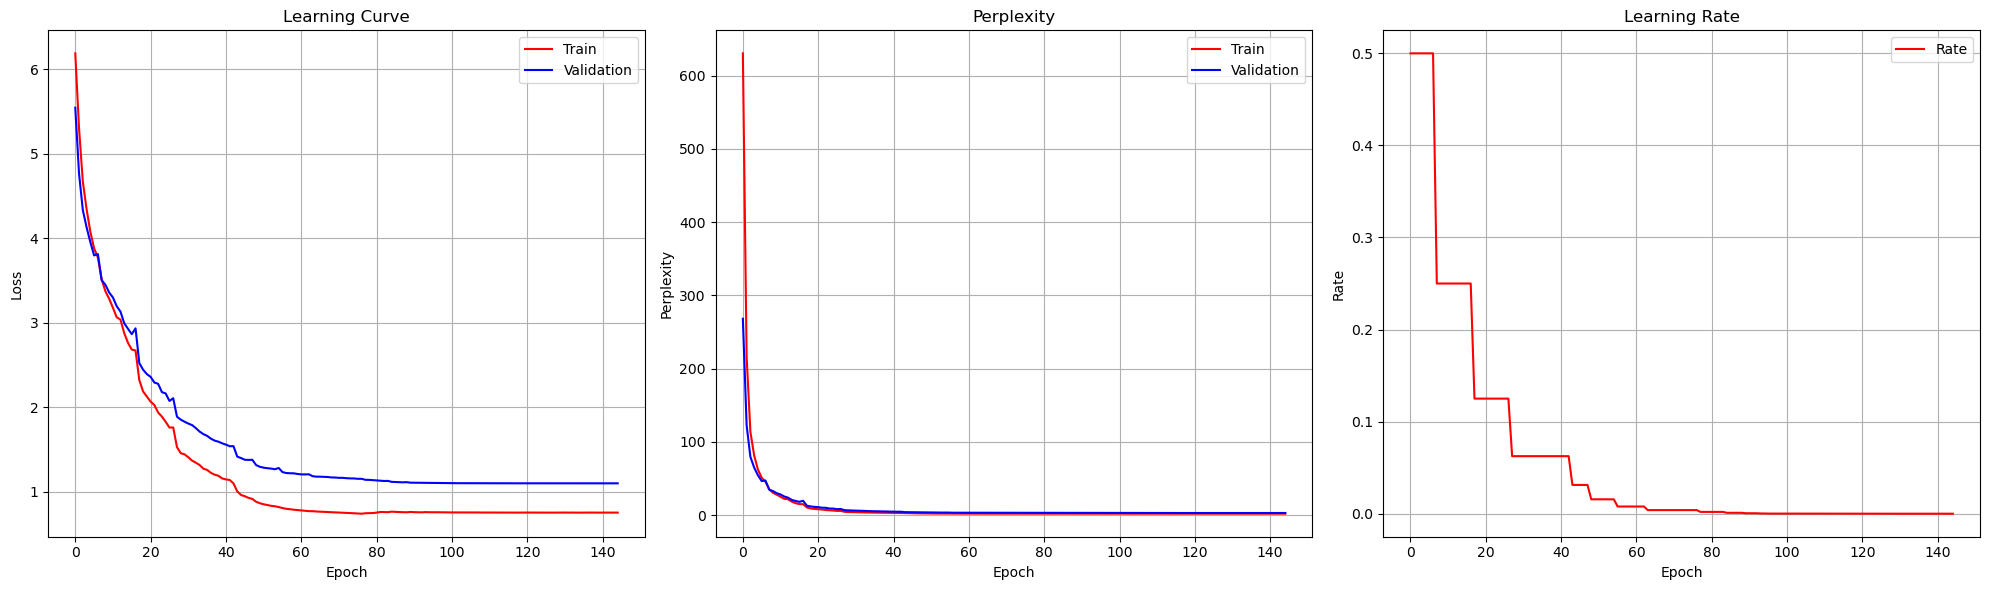

In [21]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [17]:

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

/tmp/ipykernel_3111/1059837893.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input), torch.tensor(target)


Validation: Loss = 1.097 , Perplexity = 3.069
Test: Loss = 1.07 , Perplexity = 2.987


# Text Generation

In [19]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33278, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33278, bias=True)
)

In [20]:
num_trainable_params(model)

39.323278

In [21]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [char2ind[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = findWordByToken(next_token_id)
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "the machines can"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

the machines can lead in the year system at initial low rates that affected the activity for economic activity , more significantly over years time .
